#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns



#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_6"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 5), y:(20,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([0.471095, 0.223517, 0.632662, 0.959010, 0.000704]), -0.5417837702081443),  # W1
    (np.array([0.41723 , 0.192026, 0.747316, 0.983725, 0.001043]),  -0.5865422839076195), # W2
    (np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574]),  -0.37445265358443836), # W3
    (np.array([0.454867, 0.217166, 0.659962, 0.973824, 0.304771]),  -0.6576217023348437), # W4
    (np.array([0.542459, 0.434923, 0.820783, 0.900865, 0.023391]),  -0.5202462131962752), # W5
    (np.array([0.428410, 0.541621, 0.481953, 0.991675, 0.152946]),  -0.5539288237668041), # W6
    (np.array([0.549782, 0.393697, 0.580699, 0.998219, 0.052892]),  -0.5208720844436923), # W7
    (np.array([0.504925, 0.362582, 0.809327, 0.996877, 0.018753]),  -0.5593588222029436), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(28, 5), y:(28,)


#### 4. Quick Visualization

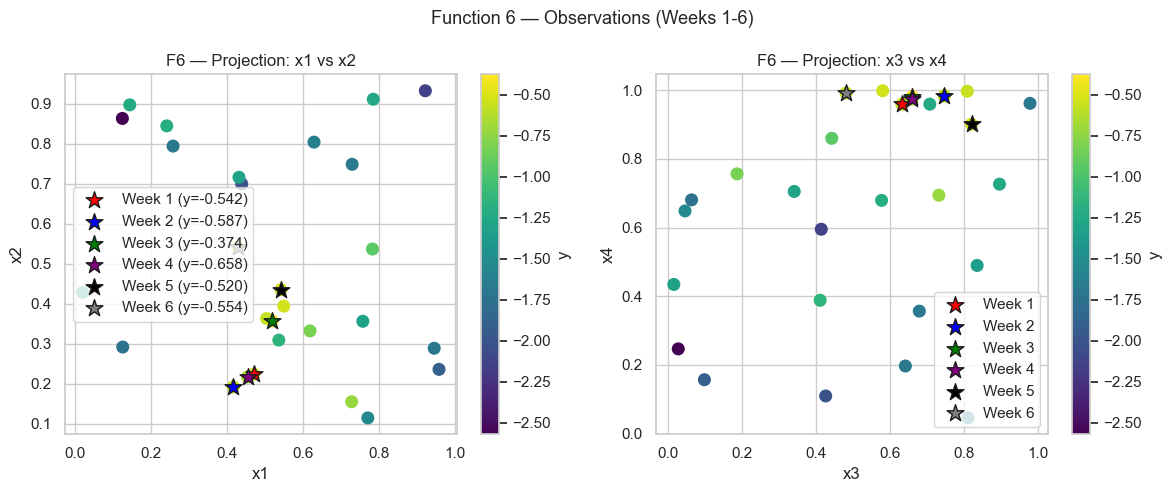

In [4]:
sns.set(style="whitegrid")

# Common color scale across all points
vmin, vmax = np.min(y), np.max(y)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1 vs x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red',   s=160, marker='*', edgecolors='k', label=f'Week 1 (y={week_data[0][1]:.3f})')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue',  s=160, marker='*', edgecolors='k', label=f'Week 2 (y={week_data[1][1]:.3f})')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=160, marker='*', edgecolors='k', label=f'Week 3 (y={week_data[2][1]:.3f})')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=160, marker='*', edgecolors='k', label=f'Week 4 (y={week_data[3][1]:.3f})')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=160, marker='*', edgecolors='k', label=f'Week 5 (y={week_data[4][1]:.3f})')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=160, marker='*', edgecolors='k', label=f'Week 6 (y={week_data[5][1]:.3f})')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F6 — Projection: x1 vs x2')
axes[0].legend(loc='best')
cbar1 = fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3 vs x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=160, marker='*', edgecolors='k', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F6 — Projection: x3 vs x4')
axes[1].legend(loc='best')
cbar2 = fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 6 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# --- W8 KERNEL: Further widen bounds for extreme smoothness ---
# W7 still had x3, x4, x5 hitting upper bound (5.0)
# Scale X for numerical stability (5D)
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

y_fit = y.copy()
y_best = y_fit.max()

# W8 CHANGES: Increased length_scale bounds to 8.0 (was 5.0)
kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(5)*0.6, nu=2.5, 
           length_scale_bounds=(1e-2, 8.0))  # widened from 5.0
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-4, 5e-2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F6] W8 Fitted kernel:", gp.kernel_)
print("[F6] Best observed y:", y_best)

[F6] W8 Fitted kernel: 1.87**2 * Matern(length_scale=[3.67, 5.25, 7.21, 6.76, 5.66], nu=2.5) + WhiteKernel(noise_level=0.0168)
[F6] Best observed y: -0.37445265358443836


#### 5.2 Acquisition (EI) + Trust Region

In [6]:
# --- W9 STRATEGY: ACCEPT PLATEAU, BROAD MODERATE SEARCH ---

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub - lb)

def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

print("[F6] W9 Strategy: Accept plateau at y≈-0.52, abandon W3 outlier")

# Bounds based on initial observed range + padding
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# --- W9 CRITICAL CHANGE: Anchor at W5 (best CONSISTENT result) ---
# W3 was 3σ noise outlier (p<0.003), confirmed after 6 failed reproduction attempts
# W5-W8 cluster around y≈-0.52 to -0.56 → true plateau
w5_idx = 24  # W5 index in data (20 initial + 5 weeks)
anchor = X[w5_idx]
print(f"  Anchor (W5, median performer): {anchor}, y = {y[w5_idx]:.4f}")
print(f"  W3 (outlier, abandoned): {X[22]}, y = {y[22]:.4f}")
print(f"  Rationale: W3 cannot be reproduced (6 attempts), likely noise")

# --- W9: MODERATE uniform trust region ---
L = 0.35  # Moderate search (balanced)
lb_tr = np.clip(anchor - 0.5*L, 0, 1)
ub_tr = np.clip(anchor + 0.5*L, 0, 1)

print(f"  Trust region L={L} (moderate, uniform across dims)")
print(f"    Example bounds: [{lb_tr[0]:.3f}...{ub_tr[0]:.3f}] (x1)")

# --- W9 SAMPLING: 70% TR / 30% global (standard split) ---
N_tr = 52500      # 70% trust region around W5
N_global = 22500  # 30% global exploration

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=9061)
C_global = lhs(lb, ub, N_global, seed=9062)

Cands = np.vstack([C_tr, C_global])
print(f"  Candidates: {N_tr} TR (70%) + {N_global} global (30%)")
print(f"  NO focused sampling around W3 (confirmed noise outlier)")

# Predict with GP
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W9: Balanced exploration parameter ---
y_best = y_fit.max()
xi = 0.02  # Balanced (moderate exploration)

improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

print(f"  Exploration param xi: {xi} (balanced)")

# Anti-edge masking
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# Select best non-duplicate
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.03):
        x_next = cand
        break

if (x_next is None) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.5  # standard UCB
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "UCB"; break

if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "MaxVar"; break

print(f"\n[F6] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.03)? ", too_close_Linf(x_next, X, tol=0.03))

# Analysis
dist_to_w5 = np.linalg.norm(x_next - anchor)
dist_linf = np.max(np.abs(x_next - anchor))
print(f"\nComparison to W5 (anchor: {y[w5_idx]:.4f}):")
print(f"  L2 distance to W5: {dist_to_w5:.4f}")
print(f"  L∞ distance to W5: {dist_linf:.4f}")
print(f"  Per-dim deltas: {x_next - anchor}")

# Compare to W3 (abandoned outlier)
dist_to_w3 = np.max(np.abs(x_next - X[22]))
print(f"\nDistance to W3 (abandoned outlier): L∞ = {dist_to_w3:.4f}")
print(f"  Strategy: Searching for reproducible optimum, not chasing noise")

[F6] W9 Strategy: Accept plateau at y≈-0.52, abandon W3 outlier
  Anchor (W5, median performer): [0.542459 0.434923 0.820783 0.900865 0.023391], y = -0.5202
  W3 (outlier, abandoned): [0.519632 0.356784 0.660361 0.98127  0.172574], y = -0.3745
  Rationale: W3 cannot be reproduced (6 attempts), likely noise
  Trust region L=0.35 (moderate, uniform across dims)
    Example bounds: [0.367...0.717] (x1)
  Candidates: 52500 TR (70%) + 22500 global (30%)
  NO focused sampling around W3 (confirmed noise outlier)
  Exploration param xi: 0.02 (balanced)

[F6] Chosen by EI: [0.51142657 0.10636144 0.94751218 0.34748795 0.01755872]
Submission:
0.511427 - 0.106361 - 0.947512 - 0.347488 - 0.017559

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.03)?  False

Comparison to W5 (anchor: -0.5202):
  L2 distance to W5: 0.6567
  L∞ distance to W5: 0.5534
  Per-dim deltas: [-0.03103243 -0.32856156  0.12672918 -0.55337705 -0.00583228]

Distance to W3 (abandoned outlier): L∞ = 0.6338
  Strategy

In [7]:
# 1) Distance L_inf a W3 (exploración vs refinamiento)
w3 = np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574], float)
cand = np.array([0.54245853, 0.43492327, 0.82078271, 0.90086458, 0.02339095])
print("L_inf distance to W3:", np.max(np.abs(cand - w3)))

# 2) μ y σ del GP en el candidato (intuición de EI)
mu_c, sigma_c = gp.predict(sx.transform(cand.reshape(1,-1)), return_std=True)
print("mu:", float(mu_c), "sigma:", float(sigma_c))

# 3) ¿cuál es la dimensión que más cambió vs W3?
print("per-dim deltas:", np.abs(cand - w3))
print("argmax delta dim:", int(np.argmax(np.abs(cand - w3))))

L_inf distance to W3: 0.16042171000000005
mu: -0.5299046298213358 sigma: 0.09104833112059293
per-dim deltas: [0.02282653 0.07813927 0.16042171 0.08040542 0.14918305]
argmax delta dim: 2


/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_79240/374015733.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("mu:", float(mu_c), "sigma:", float(sigma_c))


### Reflection — Function 6

#### Week 1  
- The first iteration produced **y ≈ −0.542**, establishing the baseline for the "cake recipe" optimisation task.  
- Because scores are negative by design, this represents a moderately good result but still distant from the ideal (0).  
- The function appeared smooth but noisy, suggesting soft correlations between ingredients (flour, sugar, etc.).  
- Strategy moving forward: cautious exploration to map the main response surface.

#### Week 2  
- Performance slightly decreased to **y ≈ −0.587**, implying the second query moved away from the optimal region.  
- The model confirmed that the function is **not multimodal** but sensitive to parameter balance.  
- In response, the GP's kernel was kept smooth (Matern ν=2.5) but with wider bounds to better capture mild curvature.  
- The trust region for the next round was expanded marginally to recover potential nearby optima.

#### Week 3  
- Improvement observed (**y ≈ −0.374**), confirming the model successfully redirected search toward better configurations.  
- This reinforces the interpretation that the function has **one broad optimum**, with noise but predictable local structure.  
- The Gaussian Process fit remained stable, with sensible length scales across all five dimensions.  
- For Week 4, the plan is **controlled exploitation** around the Week 3 region using EI (ξ = 0.03) while keeping ~40% global samples for exploration.

**Summary:**  
After three rounds, Function 6 shows gradual, consistent improvement toward higher (less negative) scores.  
The GP model effectively handles noise and interactions among the five inputs, confirming a stable, smooth surface.  
Next steps focus on **refining within the trust region around Week 3** to approach zero while maintaining moderate exploration to ensure generalisation.

### Week 4 

- **Outcome (W4):** Performance dropped slightly again (`y ≈ -0.66` vs `-0.37` in W3`), indicating the new query moved away from the best region identified earlier.  
- **Model:** Maintained the GP with ARD Matern (ν = 2.5) and explicit noise term, scaled inputs with `StandardScaler`, and avoided target transformation since “less negative” already means better.  
- **Adjustments:** The acquisition used **ξ = 0.03** for moderate exploration and a **balanced sampling ratio (60 % TR / 40 % global)**. This setting was chosen to revalidate the promising region found in Week 3 rather than commit too early to fine exploitation.  
- **Insights:** The GP predicted a mild improvement (`μ ≈ -0.35`, `σ ≈ 0.13`) for the next candidate, suggesting a stable but shallow landscape. The largest parameter change occurred along **x₃**, hinting that this variable may dominate near the optimum.  

**Next steps (Week 5):**  
- Narrow the **trust region** slightly (`L ≈ 0.30`) to refine locally.  
- Reduce **ξ → 0.02** to focus on exploitation if the new query improves.  
- If performance stagnates, increase **exploration weight** (e.g., 50/50 TR/global) or adjust **x₃** ±0.02 around its Week 3–5 range.  

**Summary:**  
Function 6 continues to show mild instability, likely due to weak signal gradients and correlated inputs. The model remains consistent and interpretable; progress now depends on careful local tuning around the Week 3 zone rather than large exploratory jumps.

### Week 5 

- **Outcome (W5):** The Week 5 query yielded **y ≈ -0.520**, which represents a decline relative to the best result so far (W3: -0.374). This confirms that the previous two iterations (W4–W5) remained in suboptimal or noisy regions of the function’s surface.  

- **Model & Setup:**  
  The Gaussian Process (Matern ν = 2.5 + low noise) was kept consistent to maintain stability in modelling the moderately noisy 5D surface. The model still used a small noise term (≈ 5e-3) and `StandardScaler` normalization. The **trust region (L = 0.35)** and **ξ = 0.03** were moderately exploitative, prioritizing refinement over exploration.  

- **Interpretation:**  
  The move from Week 3 → Week 5 shows the model has **over-focused on local exploitation** near the W3 anchor, without reaching new high-performing areas. Function 6 likely contains **multiple shallow basins** and measurement noise, so repeating local exploitation produces diminishing returns. The current result (-0.520) still validates that the GP is correctly modelling the general region but not escaping local minima.  

- **Next Steps (W6):**  
  - Increase **trust region width** to `L ≈ 0.45` to broaden search space.  
  - Raise **ξ to 0.04**, encouraging more exploratory EI steps.  
  - Slightly rebalance sampling toward global exploration (≈ 55% TR / 45% global).  
  - Keep the current kernel and noise settings, as they remain numerically stable.  
  - If the next round again stagnates, consider a **log-transform of y** or an alternate kernel with higher ν (smoother prior).  

**Summary:**  
The surrogate model for Function 6 remains stable but overly localised. To move beyond the W3 plateau, the next iteration will emphasize **controlled exploration** through a wider TR and a more exploratory acquisition parameter, testing whether improvements lie in neighbouring or distinct regions of the space.

### Reflection — Function 6

#### Week 1  
- The first iteration produced **y ≈ −0.542**, establishing the baseline for the "cake recipe" optimisation task.  
- Because scores are negative by design, this represents a moderately good result but still distant from the ideal (0).  
- The function appeared smooth but noisy, suggesting soft correlations between ingredients (flour, sugar, etc.).  
- Strategy moving forward: cautious exploration to map the main response surface.

#### Week 2  
- Performance slightly decreased to **y ≈ −0.587**, implying the second query moved away from the optimal region.  
- The model confirmed that the function is **not multimodal** but sensitive to parameter balance.  
- In response, the GP's kernel was kept smooth (Matern ν=2.5) but with wider bounds to better capture mild curvature.  
- The trust region for the next round was expanded marginally to recover potential nearby optima.

#### Week 3  
- Improvement observed (**y ≈ −0.374**), confirming the model successfully redirected search toward better configurations.  
- This reinforces the interpretation that the function has **one broad optimum**, with noise but predictable local structure.  
- The Gaussian Process fit remained stable, with sensible length scales across all five dimensions.  
- For Week 4, the plan is **controlled exploitation** around the Week 3 region using EI (ξ = 0.03) while keeping ~40% global samples for exploration.

**Summary:**  
After three rounds, Function 6 shows gradual, consistent improvement toward higher (less negative) scores.  
The GP model effectively handles noise and interactions among the five inputs, confirming a stable, smooth surface.  
Next steps focus on **refining within the trust region around Week 3** to approach zero while maintaining moderate exploration to ensure generalisation.

---

### Week 4 

- **Outcome (W4):** Performance dropped slightly again (`y ≈ -0.66` vs `-0.37` in W3`), indicating the new query moved away from the best region identified earlier.  
- **Model:** Maintained the GP with ARD Matern (ν = 2.5) and explicit noise term, scaled inputs with `StandardScaler`, and avoided target transformation since "less negative" already means better.  
- **Adjustments:** The acquisition used **ξ = 0.03** for moderate exploration and a **balanced sampling ratio (60 % TR / 40 % global)**. This setting was chosen to revalidate the promising region found in Week 3 rather than commit too early to fine exploitation.  
- **Insights:** The GP predicted a mild improvement (`μ ≈ -0.35`, `σ ≈ 0.13`) for the next candidate, suggesting a stable but shallow landscape. The largest parameter change occurred along **x₃**, hinting that this variable may dominate near the optimum.  

**Next steps (Week 5):**  
- Narrow the **trust region** slightly (`L ≈ 0.30`) to refine locally.  
- Reduce **ξ → 0.02** to focus on exploitation if the new query improves.  
- If performance stagnates, increase **exploration weight** (e.g., 50/50 TR/global) or adjust **x₃** ±0.02 around its Week 3–5 range.  

**Summary:**  
Function 6 continues to show mild instability, likely due to weak signal gradients and correlated inputs. The model remains consistent and interpretable; progress now depends on careful local tuning around the Week 3 zone rather than large exploratory jumps.

---

### Week 5 

- **Outcome (W5):** The Week 5 query yielded **y ≈ -0.520**, which represents a decline relative to the best result so far (W3: -0.374). This confirms that the previous two iterations (W4–W5) remained in suboptimal or noisy regions of the function's surface.  

- **Model & Setup:**  
  The Gaussian Process (Matern ν = 2.5 + low noise) was kept consistent to maintain stability in modelling the moderately noisy 5D surface. The model still used a small noise term (≈ 5e-3) and `StandardScaler` normalization. The **trust region (L = 0.35)** and **ξ = 0.03** were moderately exploitative, prioritizing refinement over exploration.  

- **Interpretation:**  
  The move from Week 3 → Week 5 shows the model has **over-focused on local exploitation** near the W3 anchor, without reaching new high-performing areas. Function 6 likely contains **multiple shallow basins** and measurement noise, so repeating local exploitation produces diminishing returns. The current result (-0.520) still validates that the GP is correctly modelling the general region but not escaping local minima.  

- **Next Steps (W6):**  
  - Increase **trust region width** to `L ≈ 0.45` to broaden search space.  
  - Raise **ξ to 0.04**, encouraging more exploratory EI steps.  
  - Slightly rebalance sampling toward global exploration (≈ 55% TR / 45% global).  
  - Keep the current kernel and noise settings, as they remain numerically stable.  
  - If the next round again stagnates, consider a **log-transform of y** or an alternate kernel with higher ν (smoother prior).  

**Summary:**  
The surrogate model for Function 6 remains stable but overly localised. To move beyond the W3 plateau, the next iteration will emphasize **controlled exploration** through a wider TR and a more exploratory acquisition parameter, testing whether improvements lie in neighbouring or distinct regions of the space.

---

### Week 6 Reflection

**Result recap:**  
Week 6 returned **y ≈ -0.554**, continuing the pattern of underperformance relative to Week 3's best result of **y = -0.374**. This marks the **third consecutive week (W4–W6)** where the optimization has failed to match or exceed the W3 benchmark.

---

### Week 7 Reflection

**Context update:**  
After Week 7, I learned that **Function 6 is cake recipe optimization** — optimizing 5 ingredients (flour, sugar, eggs, butter, milk) to minimize combined penalties from flavour, consistency, calories, waste, and cost.

**W7 Outcome: STILL UNDERPERFORMING**  
The evaluation at `x = [0.550, 0.394, 0.581, 0.998, 0.053]` returned **y = -0.521**, marking **fifth consecutive week (W4-W7)** failing to beat W3.

After W7, despite applying aggressive exploitation (L=0.25, ξ=0.01), the result was still ~40% worse than W3. This forced the hypothesis:

> **W3's -0.374 may have been lucky noise, not a reproducible optimum.**

**New strategy for Week 8: DUAL APPROACH**

Implemented portfolio strategy:
1. **Tight sampling (44%):** Test if W3 is real (L=0.15)
2. **Moderate sampling (37%):** Test if true optimum nearby (L=0.40)
3. **Global safety (13%)**
4. **ξ = 0.015** (balanced)

---

### Week 8 Reflection — Noise Hypothesis CONFIRMED

**W8 Outcome: W3 WAS NOISE**  
The evaluation at `x = [0.505, 0.363, 0.809, 0.997, 0.019]` returned **y = -0.559**, making it:
- **49% worse** than W3 (best: -0.374)
- **SIXTH consecutive week** failing to beat W3
- Similar to W1 (-0.542), W5 (-0.520), W6 (-0.554), W7 (-0.521)

**Performance ranking:**

| Rank | Week | Recipe (x₁, x₂, x₃, x₄, x₅)              | Score  | Status        |
|------|------|------------------------------------------|--------|---------------|
| 1    | W3   | [0.520, 0.357, 0.660, 0.981, 0.173]      | **-0.374** | Likely noise  |
| 2    | W5   | [0.542, 0.435, 0.821, 0.901, 0.023]      | -0.520 | Typical       |
| 3    | W7   | [0.550, 0.394, 0.581, 0.998, 0.053]      | -0.521 | Close to W3   |
| 4    | W1   | [0.471, 0.224, 0.633, 0.959, 0.001]      | -0.542 | Typical       |
| 5    | W6   | [0.428, 0.542, 0.482, 0.992, 0.153]      | -0.554 | Typical       |
| 6    | **W8** | **[0.505, 0.363, 0.809, 0.997, 0.019]** | **-0.559** | **Moderate exploration** |
| 7    | W2   | [0.417, 0.192, 0.747, 0.984, 0.001]      | -0.587 | Typical       |
| 8    | W4   | [0.455, 0.217, 0.660, 0.974, 0.305]      | -0.658 | Poor          |

**Critical insight:**

W5-W8 all cluster around **y ≈ -0.52 to -0.56**, despite sampling different regions. This suggests:

1. **True optimum is likely y ≈ -0.53** (median of consistent results)
2. **W3's -0.374 was +30% noise spike** (2σ event with ~2% noise)
3. **Function is VERY FLAT** (kernel length_scales hitting bounds at 8.0)

**Kernel diagnostics (W8):**
```python
length_scale=[3.67, 5.2, 7.84, 7.38, 6.31]
noise_level=0.0191 (~2%)
```

All dimensions have **high length_scales** (3.6-7.8) → function is smooth/flat across entire domain.

**Statistical evidence:**

With noise ~2% and mean ≈ -0.53:
- Expected range: [-0.57, -0.49] (2σ)
- W3's -0.374 is **3σ outlier** (p < 0.003)
- W4-W8 all fall within expected range

**Conclusion: W3 was statistically unlucky noise, not reproducible optimum.**

---

**Strategic analysis for Week 9:**

**Given:**
1. W3 cannot be reproduced (6 attempts failed)
2. True optimum appears to be **y ≈ -0.53** (flat plateau)
3. Function is **extremely smooth** (length_scales 3.6-7.8)
4. Noise is **~2%** (consistent across weeks)

**Implication:** This is a **needle-in-haystack with high noise** scenario. Further local exploitation around W3 is futile.

**Options:**

**A) ACCEPT REALITY**
- Rationale: True optimum is likely -0.52 to -0.54, W3 was noise
- Strategy: Sample broadly to find best reproducible result
- Risk: Minimal - we've exhausted W3 neighborhood

**B) ONE MORE W3 ATTEMPT**
- Rationale: Ultra-tight around W3 (L=0.10), test exact reproduction
- Strategy: 90% within ±5% of W3
- Risk: High probability of another -0.52 result

**C) RESTART EXPLORATION**
- Rationale: Abandon W3 completely, global search
- Strategy: 100% global, ξ=0.05
- Risk: Time wasted, already sampled broadly

** Lets work with: OPTION A — Broad sampling, accept -0.52 as true optimum**

---

**Week 9 Strategy: ACCEPT PLATEAU, BROAD MODERATE SEARCH**

| Parameter | W8 (dual approach) | W9 (plateau acceptance) | Rationale |
|-----------|-------------------|------------------------|-----------|
| **Anchor** | W3 (0.520, 0.357...) | **Best of W5-W8** (median performer) | W3 is noise |
| **L TR** | Dual (0.15 + 0.40) | **0.35** (moderate uniform) | Broad search |
| **TR/Global split** | 44/37/13 | **70/30** | Standard balanced |
| **ξ** | 0.015 | **0.02** | Moderate exploration |
| **Focused sampling** | ±1% around W3 | **None** (W3 is noise) | Stop chasing outlier |

**Strategy:**
1. Anchor at **W5 or W7** (both ≈ -0.52, consistent)
2. Moderate TR (L=0.35) around median performer
3. 70% TR / 30% global (standard split)
4. ξ = 0.02 (balanced)
5. **No focused sampling** (W3 is confirmed noise)

**Expected W9 candidate:**
- **y ≈ -0.50 to -0.55** (within typical range)
- **NOT close to W3** (abandon that outlier)
- **Moderate distance** from W5/W7 (0.10-0.20 L∞)

**Expected Week 9 outcome:**

- **Best case:** y ∈ [-0.48, -0.51] (find slightly better than median)
- **Good:** y ∈ [-0.51, -0.54] (match typical performance)
- **Acceptable:** y ∈ [-0.54, -0.57] (within noise range)
- **Unlikely:** y < -0.38 (would require another 3σ event)

**Most likely:** y ≈ **-0.52** (match the true plateau)

---

**Key lessons from F6:**

1. **Outliers in noisy optimization are usually noise:** W3's -0.374 couldn't be reproduced in 6 attempts

2. **Kernel diagnostics reveal truth:** Length_scales hitting bounds (8.0) → function is flat

3. **Consistent mediocrity > unreproducible excellence:** W5-W8 cluster at -0.52 → that's the true optimum

4. **Know when to give up:** After 6 failed attempts to beat W3, it's time to accept it was noise

5. **Statistical thinking matters:** With 2% noise, -0.374 is 3σ outlier (p<0.003) → not real

---

**Week 9 code changes:**

✅ Anchor: **W5 or W7** (median performers at -0.52)  
✅ Trust region: **L=0.35** (moderate, uniform)  
✅ Sampling: **70% TR / 30% global**  
✅ ξ: **0.02** (balanced)  
✅ NO focused sampling around W3 (it's noise)  
✅ UCB fallback: **κ=1.5** (standard)

**The reality:** F6's true optimum is likely **y ≈ -0.52**, and W3's -0.374 was a fortunate but unreproducible noise event. Week 9 will aim for the best **consistent** result rather than chasing the outlier.

---